In [41]:
yaml_content = """
wandb:
  parameters:
    mode: "online"
    entity: "nhtnam"
    project: "segformer3d_bsm"
    resume: "allow"
model:
  name: "segformer3d_bsm"
  parameters:
    in_channels: 3
    sr_ratios: [4, 2, 1, 1]
    embed_dims: [32, 64, 160, 256]
    patch_kernel_size: [7, 3, 3, 3]
    patch_stride: [4, 2, 2, 2]
    patch_padding: [3, 1, 1, 1]
    mlp_ratios: [4, 4, 4, 4]
    num_heads: [1, 2, 5, 8]
    depths: [2, 2, 2, 2]
    num_classes: 3
    decoder_dropout: 0.0
    decoder_head_embedding_dim: 256
    merge_modes: [
      { q_mode: null, kv_mode: "bsm", kv_r: 0.6, kv_sx: 2, kv_sy: 2, kv_sz: 2},
      { q_mode: null, kv_mode: "bsm", kv_r: 0.6, kv_sx: 2, kv_sy: 2, kv_sz: 2},
      { q_mode: "bsm", kv_mode: null, q_r: 0.4, q_sx: 2, q_sy: 2, q_sz: 2},
      { q_mode: "bsm", kv_mode: null, q_r: 0.4, q_sx: 2, q_sy: 2, q_sz: 2}
    ]
loss_fn:
  loss_type: "dice"
  loss_args: None

optimizer:
  optimizer_type: "adamw"
  optimizer_args:
    lr: 0.0001
    weight_decay: 0.01

warmup_scheduler:
  enabled: True 
  warmup_epochs: 20

train_scheduler:
  scheduler_type: 'cosine_annealing_wr'
  scheduler_args:
    t_0_epochs: 20
    t_mult: 1
    min_lr: 0.000006

sliding_window_inference:
  sw_batch_size: 8
  roi: [128, 128, 128]

training_parameters:
  seed: 42
  num_epochs: 200
  start_epoch: 0
  load_optimizer: False
  print_every: 400
  calculate_metrics: True
  grad_accumulate_steps: 1 


dataset:
  name: "brats2021_seg"
  train_dataset:
    root: "/kaggle/input/brats2021/processed_data"
    train: True

  val_dataset:
    root: "/kaggle/input/brats2021/processed_data"
    train: False

  train_dataloader:
    batch_size: 8
    shuffle: True
    num_workers: 4
    drop_last: True

  val_dataloader:
    batch_size: 1
    shuffle: False
    num_workers: 1
    drop_last: False
"""

In [42]:
import wandb
wandb.login(key="1933072940bf436f5dd1e1a14a672b93cbc017c6")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

# **utils.py**

In [ ]:
import os
import torch
import imageio
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from monai.data import MetaTensor
from sklearn.preprocessing import MinMaxScaler 
from monai.transforms import (
    Orientation, 
    EnsureType,
)
import yaml
import random
from PIL import Image
def load_nifti(fp:str) -> list:
    """
    Load a NIfTI file and return its data array and affine matrix.
    
    Parameters:
        fp (str): Path to the NIfTI file (.nii or .nii.gz).
    
    Returns:
        tuple: (nifti_scan, affine) if successful, otherwise None.
    """
    if not os.path.exists(fp):
        raise FileNotFoundError(f"File {fp} does not exist.")
    
    try:
        nifti_data = nib.load(fp)
        nifti_scan = nifti_data.get_fdata() 
        affine = nifti_data.affine 
        return nifti_scan, affine
    except Exception as e:
        raise RuntimeError(f"Error loading NIfTI file {fp}: {e}")
def load_modalities(file_path: str):
    """
    Load the modalities tensor from a .pt file.

    Args:
        file_path (str): Đường dẫn tới file .pt

    Returns:
        torch.Tensor hoặc None nếu có lỗi.
    """
    try:
        modalities = torch.load(file_path, map_location=torch.device("cpu"), weights_only=False)
        return modalities
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None
def detach_meta(x: MetaTensor) -> np.ndarray:
        if not isinstance(x, MetaTensor):
            raise TypeError("Input to `detach_meta` must be a MetaTensor.")
        return EnsureType(data_type="numpy", track_meta=False)(x)
def orient(x: MetaTensor) -> MetaTensor:
        if not isinstance(x, MetaTensor):
            raise TypeError("Input to `orient` must be a MetaTensor.")
        return Orientation(axcodes="RAS")(x)   
def normalize(x: np.ndarray) -> np.ndarray:
        try:
            scaler = MinMaxScaler(feature_range=(0, 1))
            normalized_1D_array = scaler.fit_transform(x.reshape(-1, x.shape[-1]))
            return normalized_1D_array.reshape(x.shape)
        except ValueError as e:
            raise ValueError(f"Error in normalization: {e}")
def generate_gif(x: np.ndarray, fp: str):
    imageio.mimsave(fp, (x * 255).astype(np.uint8), duration=0.1)
     
def seed_everything(seed) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def load_config(config_path: str) -> dict:
    """loads the yaml config file

    Args:
        config_path (str): _description_

    Returns:
        Dict: _description_
    """
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    return config
def visualize_result(volume, prediction, slice_idx, title):
    # volume: 3, D, H, W
    # prediction: 3, D, H, W
    D, H, W = volume.shape[1:]

    # Initialize a list to store overlayed images
    overlay_all_slices = []

    # Extract the flair modality and the prediction for the given slice
    flair_slice = volume[1, slice_idx, :, :]  # (H, W) - Flair modality
    prediction_slice = prediction[:, slice_idx, :, :]  # (3, H, W)

    # Extract WT, TC, ET masks
    wt_mask = prediction_slice[1, :, :]  # Channel 2: Whole Tumor (WT)
    tc_mask = prediction_slice[0, :, :]  # Channel 1: Tumor Core (TC)
    et_mask = prediction_slice[2, :, :]  # Channel 3: Enhancing Tumor (ET)

    # Overlay masks in priority order: ET > TC > WT
    final_mask = np.zeros_like(wt_mask)

    final_mask[et_mask > 0] = 3  # ET
    final_mask[(tc_mask > 0) & (final_mask == 0)] = 2  # TC
    final_mask[(wt_mask > 0) & (final_mask == 0)] = 1  # WT

    # Convert the flair slice to a 3-channel color image
    flair_slice_color = np.stack((flair_slice,) * 3, axis=-1)  # (H, W, 3)

    # Apply RGB overlays
    flair_slice_color[final_mask == 1] = [255, 0, 0]    # WT - Red
    flair_slice_color[final_mask == 2] = [0, 255, 0]    # TC - Green
    flair_slice_color[final_mask == 3] = [0, 0, 255]    # ET - Blue

    # Display the slice to check results
    plt.imshow(flair_slice_color)
    plt.title(title)
    plt.axis('off')
    plt.show()

def create_gif_from_volume(volume, prediction, modal=0, gif_path='output.gif', duration=0.1):
    """
    Create a GIF from all slices along the D dimension of the volume and prediction.
    - volume: tensor of shape (3, D, H, W)
    - prediction: tensor of shape (3, D, H, W)
    """
    _, D, H, W = volume.shape
    frames = []

    for slice_idx in range(D):
        flair_slice = volume[modal, slice_idx, :, :]
        prediction_slice = prediction[:, slice_idx, :, :]

        wt_mask = prediction_slice[1, :, :]
        tc_mask = prediction_slice[0, :, :]
        et_mask = prediction_slice[2, :, :]

        final_mask = np.zeros_like(wt_mask)
        final_mask[et_mask > 0] = 3
        final_mask[(tc_mask > 0) & (final_mask == 0)] = 2
        final_mask[(wt_mask > 0) & (final_mask == 0)] = 1

        flair_rgb = np.stack((flair_slice,) * 3, axis=-1)

        # Normalize and scale to [0, 255]
        max_val = flair_rgb.max()
        if max_val > 0:
            flair_rgb = np.clip(flair_rgb / max_val, 0, 1) * 255
        else:
            flair_rgb = np.zeros_like(flair_rgb)  # fallback to black image

        flair_rgb = flair_rgb.astype(np.uint8)

        # Apply color masks
        flair_rgb[final_mask == 1] = [255, 0, 0]  # WT - Red
        flair_rgb[final_mask == 2] = [0, 255, 0]  # TC - Green
        flair_rgb[final_mask == 3] = [0, 0, 255]  # ET - Blue

        # Convert to PIL image
        img_pil = Image.fromarray(flair_rgb)
        img_pil = img_pil.convert("RGB")

        # Optional: add text like "Slice: idx" using ImageDraw, ImageFont

        frames.append(img_pil)

    # Save as animated GIF
    frames[0].save(
        gif_path,
        save_all=True,
        append_images=frames[1:],
        duration=duration * 1000,
        loop=0
    )
    print(f"✅ GIF saved at: {gif_path}")

In [44]:
import torch
from typing import Tuple, Callable

def do_nothing(x: torch.Tensor, mode: str = None):
    return x

def bipartite_soft_matching_random3d(metric: torch.Tensor,
                                     d: int, h: int, w: int,
                                     sx: int, sy: int, sz: int,
                                     r: int, rand: bool = False) -> Tuple[Callable, Callable]:
    """
    3D version of bipartite soft matching with random partitioning.
    Args:
        metric [B, N, C]: similarity metric
        d, h, w: depth, height, width of the image in tokens
        sx, sy, sz: strides along width, height, and depth (must divide w, h, d)
        r: number of tokens to merge (from src to dst)
    Returns:
        merge and unmerge functions
    """
    B, N, _ = metric.shape
    if r <= 0:
        return do_nothing, do_nothing

    gather = torch.gather

    with torch.no_grad():
        dsz, hsy, wsx = d // sz, h // sy, w // sx  # output grid size
        if rand:
            rand_idx = torch.randint(0, sz * sy * sx, (dsz, hsy, wsx, 1), device=metric.device)
        else:
            rand_idx = torch.zeros(dsz, hsy, wsx, 1, device=metric.device, dtype=torch.int64)
        
        idx_buffer_view = torch.zeros(dsz, hsy, wsx, sz * sy * sx, device=metric.device, dtype=torch.int64)
        idx_buffer_view.scatter_(dim=3, index=rand_idx, src=-torch.ones_like(rand_idx, dtype=torch.int64))
        idx_buffer_view = idx_buffer_view.view(dsz, hsy, wsx, sz, sy, sx).permute(0, 3, 1, 4, 2, 5).reshape(dsz*sz, hsy*sy, wsx*sx)

        if (dsz * sz) < d or (hsy * sy) < h or (wsx * sx) < w:
            idx_buffer = torch.zeros(d, h, w, device=metric.device, dtype=torch.int64)
            idx_buffer[:(dsz * sz), :(hsy * sy), :(wsx * sx)] = idx_buffer_view
        else:
            idx_buffer = idx_buffer_view

        rand_idx = idx_buffer.reshape(1, -1, 1).argsort(dim=1)

        num_dst = dsz * hsy * wsx
        a_idx = rand_idx[:, num_dst:, :]  # src
        b_idx = rand_idx[:, :num_dst, :]  # dst

        def split(x):
            C = x.shape[-1]
            src = gather(x, dim=1, index=a_idx.expand(B, N - num_dst, C))
            dst = gather(x, dim=1, index=b_idx.expand(B, num_dst, C))
            return src, dst

        metric = metric / metric.norm(dim=-1, keepdim=True)
        a, b = split(metric)
        scores = a @ b.transpose(-1, -2)

        r_eff = min(a.shape[1], r)
        node_max, node_idx = scores.max(dim=-1)
        edge_idx = node_max.argsort(dim=-1, descending=True)[..., None]

        unm_idx = edge_idx[..., r_eff:, :]
        src_idx = edge_idx[..., :r_eff, :]
        dst_idx = gather(node_idx[..., None], dim=-2, index=src_idx)

    def merge(x: torch.Tensor, mode="mean") -> torch.Tensor:
        src, dst = split(x)
        n, t1, c = src.shape

        unm = gather(src, dim=-2, index=unm_idx.expand(n, t1 - r_eff, c))
        src = gather(src, dim=-2, index=src_idx.expand(n, r_eff, c))
        dst = dst.scatter_reduce(-2, dst_idx.expand(n, r_eff, c), src, reduce=mode)
        return torch.cat([unm, dst], dim=1)

    def unmerge(x: torch.Tensor) -> torch.Tensor:
        unm_len = unm_idx.shape[1]
        unm, dst = x[..., :unm_len, :], x[..., unm_len:, :]
        _, _, c = unm.shape

        src = gather(dst, dim=-2, index=dst_idx.expand(B, r_eff, c))
        out = torch.zeros(B, N, c, device=x.device, dtype=x.dtype)
        out.scatter_(dim=-2, index=b_idx.expand(B, num_dst, c), src=dst)
        out.scatter_(dim=-2, index=gather(a_idx.expand(B, a_idx.shape[1], 1), dim=1, index=unm_idx).expand(B, unm_len, c), src=unm)
        out.scatter_(dim=-2, index=gather(a_idx.expand(B, a_idx.shape[1], 1), dim=1, index=src_idx).expand(B, r_eff, c), src=src)
        return out

    return merge, unmerge

In [45]:
import torch
import math
from torch import nn
import sys
import os

def build_segformer3d_model(config=None):
    model = SegFormer3DPlusPlus(
        in_channels=config["model"]["parameters"]["in_channels"],
        sr_ratios=config["model"]["parameters"]["sr_ratios"],
        embed_dims=config["model"]["parameters"]["embed_dims"],
        patch_kernel_size=config["model"]["parameters"]["patch_kernel_size"],
        patch_stride=config["model"]["parameters"]["patch_stride"],
        patch_padding=config["model"]["parameters"]["patch_padding"],
        mlp_ratios=config["model"]["parameters"]["mlp_ratios"],
        num_heads=config["model"]["parameters"]["num_heads"],
        depths=config["model"]["parameters"]["depths"],
        decoder_head_embedding_dim=config["model"]["parameters"]["decoder_head_embedding_dim"],
        num_classes=config["model"]["parameters"]["num_classes"],
        decoder_dropout=config["model"]["parameters"]["decoder_dropout"],
        merge_modes=config["model"]["parameters"]["merge_modes"]
    )
    return model


class SegFormer3DPlusPlus(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        sr_ratios: list = [4, 2, 1, 1],
        embed_dims: list = [32, 64, 160, 256],
        patch_kernel_size: list = [7, 3, 3, 3],
        patch_stride: list = [4, 2, 2, 2],
        patch_padding: list = [3, 1, 1, 1],
        mlp_ratios: list = [4, 4, 4, 4],
        num_heads: list = [1, 2, 5, 8],
        depths: list = [2, 2, 2, 2],
        decoder_head_embedding_dim: int = 256,
        num_classes: int = 3,
        decoder_dropout: float = 0.0,
        merge_modes: list = []
    ):
        """
        in_channels: number of the input channels
        sr_ratios: the rates at which to down sample the sequence length of the embedded patch
        embed_dims: hidden size of the PatchEmbedded input
        patch_kernel_size: kernel size for the convolution in the patch embedding module
        patch_stride: stride for the convolution in the patch embedding module
        patch_padding: padding for the convolution in the patch embedding module
        mlp_ratios: at which rate increasse the projection dim of the hidden_state in the mlp
        num_heads: number of attention heads
        depths: number of attention layers
        decoder_head_embedding_dim: projection dimension of the mlp layer in the all-mlp-decoder module
        num_classes: number of the output channel of the network
        decoder_dropout: dropout rate of the concatenated feature maps
        merge_modes: mode of merge strategy that using for attent efficient
        """
        super().__init__()
        self.segformer_encoder = MixVisionTransformer(
            in_channels=in_channels,
            sr_ratios=sr_ratios,
            embed_dims=embed_dims,
            patch_kernel_size=patch_kernel_size,
            patch_stride=patch_stride,
            patch_padding=patch_padding,
            mlp_ratios=mlp_ratios,
            num_heads=num_heads,
            depths=depths,
            merge_modes=merge_modes
        )
        reversed_embed_dims = embed_dims[::-1]
        self.segformer_decoder = SegFormerDecoderHead(
            input_feature_dims=reversed_embed_dims,
            decoder_head_embedding_dim=decoder_head_embedding_dim,
            num_classes=num_classes,
            dropout=decoder_dropout,
        )
    def forward(self, x):
     
        x = self.segformer_encoder(x)
        c1 = x[0]
        c2 = x[1]
        c3 = x[2]
        c4 = x[3]
        x = self.segformer_decoder(c1, c2, c3, c4)
        return x
    
# ----------------------------------------------------- encoder -----------------------------------------------------
class PatchEmbedding(nn.Module):
    def __init__(
        self,
        in_channel: int = 4,
        embed_dim: int = 768,
        kernel_size: int = 7,
        stride: int = 4,
        padding: int = 3,
    ):
        """
        in_channels: number of the channels in the input volume
        embed_dim: embedding dimmesion of the patch
        """
        super().__init__()
        self.patch_embeddings = nn.Conv3d(
            in_channel,
            embed_dim,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        patches = self.patch_embeddings(x)
        patches = patches.flatten(2).transpose(1, 2)
        patches = self.norm(patches)
        return patches


class SelfAttention(nn.Module):
    def __init__(
        self,
        embed_dim: int = 768,
        num_heads: int = 8,
        sr_ratio: int = 2,
        qkv_bias: bool = False,
        attn_dropout: float = 0.0,
        proj_dropout: float = 0.0,
        merge_mode: dict = None
    ):
        """
        embed_dim : hidden size of the PatchEmbedded input
        num_heads: number of attention heads
        sr_ratio: the rate at which to down sample the sequence length of the embedded patch
        qkv_bias: whether or not the linear projection has bias
        attn_dropout: the dropout rate of the attention component
        proj_dropout: the dropout rate of the final linear projection
        merge_mode: mode of merge strategy for efficient attention
        """
        super().__init__()
        assert (
            embed_dim % num_heads == 0
        ), "Embedding dim should be divisible by number of heads!"

        self.num_heads = num_heads
        # embedding dimesion of each attention head
        self.attention_head_dim = embed_dim // num_heads

        # The same input is used to generate the query, key, and value,
        self.query = nn.Linear(embed_dim, embed_dim, bias=qkv_bias)
        self.key_value = nn.Linear(embed_dim, 2 * embed_dim, bias=qkv_bias)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_dropout = nn.Dropout(proj_dropout)
        self.merge_mode = merge_mode

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv3d(
                embed_dim, embed_dim, kernel_size=sr_ratio, stride=sr_ratio
            )
            self.sr_norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # (batch_size, num_patches, hidden_size)
        x_q = x.clone()
        x_kv = x.clone()

        if self.sr_ratio > 1:
            B, N, C = x_kv.shape
            n = cube_root(N)
            # (batch_size, num_patches, embed_dim) -> (batch_size, embed_dim, D, H, W)
            x_kv = x_kv.permute(0, 2, 1).reshape(B, C, n, n, n)
            # (batch_size, embed_dim, D, H, W) -> (batch_size, embed_dim, D/sr_ratio, H/sr_ratio, W/sr_ratio)
            # (batch_size, embed_dim, D/sr_ratio, H/sr_ratio, W/sr_ratio) -> (batch_size, num_patches/sr_ratio^3, embed_dim)
            x_kv = self.sr(x_kv).reshape(B, C, -1).permute(0, 2, 1)
            # normalizing the layer
            x_kv = self.sr_norm(x_kv)
        if self.merge_mode["q_mode"] == "bsm":
            B, N, C = x_q.shape
            n = cube_root(N)
            merge, unmerge = bipartite_soft_matching_random3d(metric=x_q, d=n, w=n, h=n,
                                                              r=int(x_q.size()[1] * self.merge_mode['q_r']),
                                                              sx=self.merge_mode['q_sx'], sy=self.merge_mode['q_sy'],
                                                              sz=self.merge_mode['q_sz'], rand=False)
            x_q = merge(x_q)
        if self.merge_mode["kv_mode"] == "bsm":
            B, N, C = x_kv.shape
            n = cube_root(N)
            merge, unmerge = bipartite_soft_matching_random3d(metric=x_kv, d=n, w=n, h=n,
                                                              r=int(x_kv.size()[1] * self.merge_mode['kv_r']),
                                                              sx=self.merge_mode['kv_sx'], sy=self.merge_mode['kv_sy'], 
                                                              sz=self.merge_mode['kv_sz'], rand=False)
            x_kv = merge(x_kv)
        
        B, _, C = x_q.shape
        # (batch_size, num_head, num_patches, attention_head_dim)
        q = (
            self.query(x_q)
            .reshape(B, -1, self.num_heads, self.attention_head_dim)
            .permute(0, 2, 1, 3)
        )
        # (2, batch_size, num_head, num_patches, attention_head_dim)
        kv = (
            self.key_value(x_kv)
            .reshape(B, -1, 2, self.num_heads, self.attention_head_dim)
            .permute(2, 0, 3, 1, 4)
        )
        k, v = kv[0], kv[1]
        attention_score = (q @ k.transpose(-2, -1)) / math.sqrt(self.attention_head_dim)
        attention_prob = attention_score.softmax(dim=-1)
        attention_prob = self.attn_dropout(attention_prob)
        out = (attention_prob @ v).transpose(1, 2).reshape(B, -1, C)
        out = self.proj(out)
        out = self.proj_dropout(out)
        if self.merge_mode["q_mode"] == "bsm":
            out = unmerge(out)
        return out


class TransformerBlock(nn.Module):
    def __init__(
        self,
        embed_dim: int = 768,
        mlp_ratio: int = 2,
        num_heads: int = 8,
        sr_ratio: int = 2,
        qkv_bias: bool = False,
        attn_dropout: float = 0.0,
        proj_dropout: float = 0.0,
        merge_mode: dict = None
    ):
        """
        embed_dim : hidden size of the PatchEmbedded input
        mlp_ratio: at which rate increasse the projection dim of the embedded patch in the _MLP component
        num_heads: number of attention heads
        sr_ratio: the rate at which to down sample the sequence length of the embedded patch
        qkv_bias: whether or not the linear projection has bias
        attn_dropout: the dropout rate of the attention component
        proj_dropout: the dropout rate of the final linear projection
        """
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = SelfAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            sr_ratio=sr_ratio,
            qkv_bias=qkv_bias,
            attn_dropout=attn_dropout,
            proj_dropout=proj_dropout,
            merge_mode=merge_mode
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = _MLP(in_feature=embed_dim, mlp_ratio=mlp_ratio, dropout=0.0)

    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class MixVisionTransformer(nn.Module):
    def __init__(
        self,
        in_channels: int = 4,
        sr_ratios: list = [8, 4, 2, 1],
        embed_dims: list = [64, 128, 320, 512],
        patch_kernel_size: list = [7, 3, 3, 3],
        patch_stride: list = [4, 2, 2, 2],
        patch_padding: list = [3, 1, 1, 1],
        mlp_ratios: list = [2, 2, 2, 2],
        num_heads: list = [1, 2, 5, 8],
        depths: list = [2, 2, 2, 2],
        merge_modes: list = []
    ):
        """
        in_channels: number of the input channels
        img_volume_dim: spatial resolution of the image volume (Depth, Width, Height)
        sr_ratios: the rates at which to down sample the sequence length of the embedded patch
        embed_dims: hidden size of the PatchEmbedded input
        patch_kernel_size: kernel size for the convolution in the patch embedding module
        patch_stride: stride for the convolution in the patch embedding module
        patch_padding: padding for the convolution in the patch embedding module
        mlp_ratio: at which rate increasse the projection dim of the hidden_state in the mlp
        num_heads: number of attenion heads
        depth: number of attention layers
        """
        super().__init__()
        self.embed_1 = PatchEmbedding(
            in_channel=in_channels,
            embed_dim=embed_dims[0],
            kernel_size=patch_kernel_size[0],
            stride=patch_stride[0],
            padding=patch_padding[0],
        )
        self.embed_2 = PatchEmbedding(
            in_channel=embed_dims[0],
            embed_dim=embed_dims[1],
            kernel_size=patch_kernel_size[1],
            stride=patch_stride[1],
            padding=patch_padding[1],
        )
        self.embed_3 = PatchEmbedding(
            in_channel=embed_dims[1],
            embed_dim=embed_dims[2],
            kernel_size=patch_kernel_size[2],
            stride=patch_stride[2],
            padding=patch_padding[2],
        )
        self.embed_4 = PatchEmbedding(
            in_channel=embed_dims[2],
            embed_dim=embed_dims[3],
            kernel_size=patch_kernel_size[3],
            stride=patch_stride[3],
            padding=patch_padding[3],
        )

        # block 1
        self.tf_block1 = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim=embed_dims[0],
                    num_heads=num_heads[0],
                    mlp_ratio=mlp_ratios[0],
                    sr_ratio=sr_ratios[0],
                    qkv_bias=True,
                    merge_mode = merge_modes[0]
                )
                for _ in range(depths[0])
            ]
        )
        self.norm1 = nn.LayerNorm(embed_dims[0])

        # block 2
        self.tf_block2 = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim=embed_dims[1],
                    num_heads=num_heads[1],
                    mlp_ratio=mlp_ratios[1],
                    sr_ratio=sr_ratios[1],
                    qkv_bias=True,
                    merge_mode = merge_modes[1]
                )
                for _ in range(depths[1])
            ]
        )
        self.norm2 = nn.LayerNorm(embed_dims[1])

        # block 3
        self.tf_block3 = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim=embed_dims[2],
                    num_heads=num_heads[2],
                    mlp_ratio=mlp_ratios[2],
                    sr_ratio=sr_ratios[2],
                    qkv_bias=True,
                    merge_mode = merge_modes[2]
                )
                for _ in range(depths[2])
            ]
        )
        self.norm3 = nn.LayerNorm(embed_dims[2])

        # block 4
        self.tf_block4 = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim=embed_dims[3],
                    num_heads=num_heads[3],
                    mlp_ratio=mlp_ratios[3],
                    sr_ratio=sr_ratios[3],
                    qkv_bias=True,
                    merge_mode = merge_modes[3]
                )
                for _ in range(depths[3])
            ]
        )
        self.norm4 = nn.LayerNorm(embed_dims[3])

    def forward(self, x):
        out = []
        # at each stage these are the following mappings:
        # (batch_size, num_patches, hidden_state)
        # (num_patches,) -> (D, H, W)
        # (batch_size, num_patches, hidden_state) -> (batch_size, hidden_state, D, H, W)

        # stage 1
        x = self.embed_1(x)
        B, N, C = x.shape
        n = cube_root(N)
        for i, blk in enumerate(self.tf_block1):
            x = blk(x)
        x = self.norm1(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, n, n, n, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        # stage 2
        x = self.embed_2(x)
        B, N, C = x.shape
        n = cube_root(N)
        for i, blk in enumerate(self.tf_block2):
            x = blk(x)
        x = self.norm2(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, n, n, n, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        # stage 3
        x = self.embed_3(x)
        B, N, C = x.shape
        n = cube_root(N)
        for i, blk in enumerate(self.tf_block3):
            x = blk(x)
        x = self.norm3(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, n, n, n, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        # stage 4
        x = self.embed_4(x)
        B, N, C = x.shape
        n = cube_root(N)
        for i, blk in enumerate(self.tf_block4):
            x = blk(x)
        x = self.norm4(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, n, n, n, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        return out


class _MLP(nn.Module):
    def __init__(self, in_feature, mlp_ratio=2, dropout=0.0):
        super().__init__()
        out_feature = mlp_ratio * in_feature
        self.fc1 = nn.Linear(in_feature, out_feature)
        self.dwconv = DWConv(dim=out_feature)
        self.fc2 = nn.Linear(out_feature, in_feature)
        self.act_fn = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dwconv(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super().__init__()
        self.dwconv = nn.Conv3d(dim, dim, 3, 1, 1, bias=True, groups=dim)
        # added batchnorm (remove it ?)
        self.bn = nn.BatchNorm3d(dim)

    def forward(self, x):
        B, N, C = x.shape
        # (batch, patch_cube, hidden_size) -> (batch, hidden_size, D, H, W)
        # assuming D = H = W, i.e. cube root of the patch is an integer number!
        n = cube_root(N)
        x = x.transpose(1, 2).view(B, C, n, n, n)
        x = self.dwconv(x)
        # added batchnorm (remove it ?)
        x = self.bn(x)
        x = x.flatten(2).transpose(1, 2)
        return x

###################################################################################
def cube_root(n):
    return round(math.pow(n, (1 / 3)))
    

###################################################################################
# ----------------------------------------------------- decoder -------------------
class MLP_(nn.Module):
    """
    Linear Embedding
    """

    def __init__(self, input_dim=2048, embed_dim=768):
        super().__init__()
        self.proj = nn.Linear(input_dim, embed_dim)
        self.bn = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2).contiguous()
        x = self.proj(x)
        # added batchnorm (remove it ?)
        x = self.bn(x)
        return x


###################################################################################
class SegFormerDecoderHead(nn.Module):
    """
    SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers
    """

    def __init__(
        self,
        input_feature_dims: list = [512, 320, 128, 64],
        decoder_head_embedding_dim: int = 256,
        num_classes: int = 3,
        dropout: float = 0.0,
    ):
        """
        input_feature_dims: list of the output features channels generated by the transformer encoder
        decoder_head_embedding_dim: projection dimension of the mlp layer in the all-mlp-decoder module
        num_classes: number of the output channels
        dropout: dropout rate of the concatenated feature maps
        """
        super().__init__()
        self.linear_c4 = MLP_(
            input_dim=input_feature_dims[0],
            embed_dim=decoder_head_embedding_dim,
        )
        self.linear_c3 = MLP_(
            input_dim=input_feature_dims[1],
            embed_dim=decoder_head_embedding_dim,
        )
        self.linear_c2 = MLP_(
            input_dim=input_feature_dims[2],
            embed_dim=decoder_head_embedding_dim,
        )
        self.linear_c1 = MLP_(
            input_dim=input_feature_dims[3],
            embed_dim=decoder_head_embedding_dim,
        )
        # convolution module to combine feature maps generated by the mlps
        self.linear_fuse = nn.Sequential(
            nn.Conv3d(
                in_channels=4 * decoder_head_embedding_dim,
                out_channels=decoder_head_embedding_dim,
                kernel_size=1,
                stride=1,
                bias=False,
            ),
            nn.BatchNorm3d(decoder_head_embedding_dim),
            nn.ReLU(),
        )
        self.dropout = nn.Dropout(dropout)

        # final linear projection layer
        self.linear_pred = nn.Conv3d(
            decoder_head_embedding_dim, num_classes, kernel_size=1
        )

        # segformer decoder generates the final decoded feature map size at 1/4 of the original input volume size
        self.upsample_volume = nn.Upsample(
            scale_factor=4.0, mode="trilinear", align_corners=False
        )

    def forward(self, c1, c2, c3, c4):
       ############## _MLP decoder on C1-C4 ###########
        n, _, _, _, _ = c4.shape

        _c4 = (
            self.linear_c4(c4)
            .permute(0, 2, 1)
            .reshape(n, -1, c4.shape[2], c4.shape[3], c4.shape[4])
            .contiguous()
        )
        _c4 = torch.nn.functional.interpolate(
            _c4,
            size=c1.size()[2:],
            mode="trilinear",
            align_corners=False,
        )

        _c3 = (
            self.linear_c3(c3)
            .permute(0, 2, 1)
            .reshape(n, -1, c3.shape[2], c3.shape[3], c3.shape[4])
            .contiguous()
        )
        _c3 = torch.nn.functional.interpolate(
            _c3,
            size=c1.size()[2:],
            mode="trilinear",
            align_corners=False,
        )

        _c2 = (
            self.linear_c2(c2)
            .permute(0, 2, 1)
            .reshape(n, -1, c2.shape[2], c2.shape[3], c2.shape[4])
            .contiguous()
        )
        _c2 = torch.nn.functional.interpolate(
            _c2,
            size=c1.size()[2:],
            mode="trilinear",
            align_corners=False,
        )

        _c1 = (
            self.linear_c1(c1)
            .permute(0, 2, 1)
            .reshape(n, -1, c1.shape[2], c1.shape[3], c1.shape[4])
            .contiguous()
        )

        _c = self.linear_fuse(torch.cat([_c4, _c3, _c2, _c1], dim=1))

        x = self.dropout(_c)
        x = self.linear_pred(x)
        x = self.upsample_volume(x)
        return x

In [46]:
def build_architecture(config):
    if config["model"]['name'] == "segformer3d_esa":
        print("Building segformer3d with ESA")
        model = build_segformer3d_model(config)
        return model
    elif config["model"]['name'] == "segformer3d_bsm":
        print("Building segformer3d with BMA")
        model = build_segformer3d_model(config)
        return model
    elif config["model"]['name'] == "segformer3d_epa":
        print("Building segformer3d with EPA")
        model = build_segformer3d_model(config)
        return model
    else:
        return ValueError(
            "specified model not supported, edit build_architecture.py file"
        )

In [47]:
from typing import Dict
import torch.optim as optim


######################################################################
def optim_adam(model, optimizer_args):
    adam = optim.Adam(
        model.parameters(),
        lr=optimizer_args["lr"],
        weight_decay=optimizer_args.get("weight_decay"),
    )
    return adam


######################################################################
def optim_sgd(model, optimizer_args):
    adam = optim.SGD(
        model.parameters(),
        lr=optimizer_args["lr"],
        weight_decay=optimizer_args.get("weight_decay"),
        momentum=optimizer_args.get("momentum"),
    )
    return adam


######################################################################
def optim_adamw(model, optimizer_args):
    adam = optim.AdamW(
        model.parameters(),
        lr=optimizer_args["lr"],
        weight_decay=optimizer_args["weight_decay"],
        # amsgrad=True,
    )
    return adam


######################################################################
def build_optimizer(model, optimizer_type: str, optimizer_args: Dict):
    if optimizer_type == "adam":
        return optim_adam(model, optimizer_args)
    elif optimizer_type == "adamw":
        return optim_adamw(model, optimizer_args)
    elif optimizer_type == "sgd":
        return optim_sgd(model, optimizer_args)
    else:
        raise ValueError("must be adam or adamw for now")

In [48]:
from typing import Dict
import torch.optim as optim
from torch.optim.lr_scheduler import LRScheduler

##################################################################################################
def warmup_lr_scheduler(config, optimizer):
    """
    Linearly ramps up the learning rate within X
    number of epochs to the working epoch.
    Args:
        optimizer (_type_): _description_
        warmup_epochs (_type_): _description_
        warmup_lr (_type_): warmup lr should be the starting lr we want.
    """
    lambda1 = lambda epoch: (
        (epoch + 1) * 1.0 / config["warmup_scheduler"]["warmup_epochs"]
    )
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1, verbose=False)
    return scheduler


##################################################################################################
def training_lr_scheduler(config, optimizer):
    """
    Wraps a normal scheuler
    """
    scheduler_type = config["train_scheduler"]["scheduler_type"]
    if scheduler_type == "reducelronplateau":
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            factor=0.1,
            mode=config["train_scheduler"]["mode"],
            patience=config["train_scheduler"]["patience"],
            verbose=False,
            min_lr=config["train_scheduler"]["scheduler_args"]["min_lr"],
        )
        return scheduler
    elif scheduler_type == "cosine_annealing_wr":
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=config["train_scheduler"]["scheduler_args"]["t_0_epochs"],
            T_mult=config["train_scheduler"]["scheduler_args"]["t_mult"],
            eta_min=config["train_scheduler"]["scheduler_args"]["min_lr"],
            last_epoch=-1,
            verbose=False,
        )
        return scheduler
    elif scheduler_type == "poly_lr":
        scheduler = optim.lr_scheduler.PolynomialLR(
            optimizer=optimizer,
            total_iters=5,
            power=config["train_scheduler"]["scheduler_args"]["power"],
            last_epoch=-1,
        )
        return scheduler
    else:
        raise NotImplementedError("Specified Scheduler Is Not Implemented")


##################################################################################################
def build_scheduler(
    optimizer: optim.Optimizer, scheduler_type: str, config
) -> LRScheduler:
    """generates the learning rate scheduler

    Args:
        optimizer (optim.Optimizer): pytorch optimizer
        scheduler_type (str): type of scheduler

    Returns:
        LRScheduler: _description_
    """
    if scheduler_type == "warmup_scheduler":
        scheduler = warmup_lr_scheduler(config=config, optimizer=optimizer)
        return scheduler
    elif scheduler_type == "training_scheduler":
        scheduler = training_lr_scheduler(config=config, optimizer=optimizer)
        return scheduler
    else:
        raise ValueError("Invalid Input -- Check scheduler_type")

In [49]:
import torch
import monai
import torch.nn as nn
from typing import Dict
from monai import losses

class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self._loss = nn.CrossEntropyLoss(reduction="mean")

    def forward(self, predictions, targets):
        loss = self._loss(predictions, targets)
        return loss


###########################################################################
class BinaryCrossEntropyWithLogits(nn.Module):
    def __init__(self):
        super().__init__()
        self._loss = nn.BCEWithLogitsLoss(reduction="mean")

    def forward(self, predictions, tragets):
        loss = self._loss(predictions, tragets)
        return loss
###########################################################################
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self._loss = losses.DiceLoss(to_onehot_y=False, sigmoid=True)

    def forward(self, predicted, target):
        loss = self._loss(predicted, target)
        return loss


###########################################################################
class DiceCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self._loss = losses.DiceCELoss(to_onehot_y=False, sigmoid=True)

    def forward(self, predicted, target):
        loss = self._loss(predicted, target)
        return loss


###########################################################################
def build_loss_fn(loss_type: str, loss_args: Dict = None):
    if loss_type == "crossentropy":
        return CrossEntropyLoss()

    elif loss_type == "binarycrossentropy":
        return BinaryCrossEntropyWithLogits()

    elif loss_type == "dice":
        return DiceLoss()

    elif loss_type == "diceCE":
        return DiceCELoss()
        
    else:
        raise ValueError("must be cross entropy or soft dice loss for now!")

In [50]:
import torch
import torch.nn as nn
from typing import Dict
from monai.metrics import DiceMetric
from monai.transforms import Compose
from monai.data import decollate_batch
from monai.transforms import Activations
from monai.transforms import AsDiscrete
from monai.inferers import sliding_window_inference


################################################################################
class SlidingWindowInference:
    def __init__(self, roi: tuple, sw_batch_size: int):
        self.dice_metric = DiceMetric(
            include_background=True, reduction="mean_batch", get_not_nans=False
        )
        self.post_transform = Compose(
            [
                Activations(sigmoid=True),
                AsDiscrete(argmax=False, threshold=0.5),
            ]
        )
        self.sw_batch_size = sw_batch_size
        self.roi = roi

    def __call__(
        self, val_inputs: torch.Tensor, val_labels: torch.Tensor, model: nn.Module
    ):
        self.dice_metric.reset()
        logits = sliding_window_inference(
            inputs=val_inputs,
            roi_size=self.roi,
            sw_batch_size=self.sw_batch_size,
            predictor=model,
            overlap=0.5,
        )
        val_labels_list = decollate_batch(val_labels)
        val_outputs_list = decollate_batch(logits)
        val_output_convert = [
            self.post_transform(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]
        self.dice_metric(y_pred=val_output_convert, y=val_labels_list)
        # compute accuracy per channel
        acc = self.dice_metric.aggregate().cpu().numpy()
        avg_acc = acc.mean()
        # To access individual metric 
        # TC acc: acc[0]
        # WT acc: acc[1]
        # ET acc: acc[2]
        return acc


def build_metric_fn(metric_type: str, metric_arg: Dict = None):
    if metric_type == "sliding_window_inference":
        return SlidingWindowInference(
            roi=metric_arg["roi"],
            sw_batch_size=metric_arg["sw_batch_size"],
        )
    else:
        raise ValueError("must be cross sliding_window_inference!")

In [ ]:
import os
import sys
import torch
import scripts.brats_evaluate as brats_evaluate
from tqdm import tqdm
from typing import Dict
from copy import deepcopy
from termcolor import colored
from torch.utils.data import DataLoader
import monai
import kornia
import wandb
import json


#################################################################################################
class Segmentation_Trainer:
    def __init__(
        self,
        config: Dict,
        model: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        criterion: torch.nn.Module,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        warmup_scheduler: torch.optim.lr_scheduler.LRScheduler,
        training_scheduler: torch.optim.lr_scheduler.LRScheduler,
        accelerator=None,
    ) -> None:
        self.config = config
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.warmup_scheduler = warmup_scheduler
        self.training_scheduler = training_scheduler
        self.scheduler = None
        self.accelerator = accelerator
        self.wandb_tracker = accelerator.get_tracker("wandb")

        self.num_epochs = self.config["training_parameters"]["num_epochs"]
        self.print_every = self.config["training_parameters"]["print_every"]
        self.warmup_enabled = self.config["warmup_scheduler"]["enabled"]
        self.warmup_epochs = self.config["warmup_scheduler"]["warmup_epochs"]
        self.calculate_metrics = self.config["training_parameters"]["calculate_metrics"]
        self.resume = self.config['wandb']['parameters']['resume']
        self.run = wandb.init(entity=config['wandb']['parameters']['entity'], project=config['wandb']['parameters']['project'])
        self.start_epoch = 0
        self.best_val_dice = 0.0 
        self.current_epoch = 0
        if self.resume:
            self._load_checkpoint()
            self._load_best_checkpoint()
            
        # external metric functions we can add
        self.sliding_window_inference = SlidingWindowInference(
            config["sliding_window_inference"]["roi"],
            config["sliding_window_inference"]["sw_batch_size"],
        )
    def _save_checkpoint(self) -> None:
        output_dir = "checkpoint"
        os.makedirs(output_dir, exist_ok=True)
        # Save model, optimizer, scheduler, etc.
        self.accelerator.save_state(output_dir)
        # Save additional metadata (e.g., epoch)
        meta = {
            "epoch": self.current_epoch,
        }
        with open(os.path.join(output_dir, "meta.json"), "w") as f:
            json.dump(meta, f)
    
        # Upload to WandB as artifact
        artifact = wandb.Artifact(output_dir, type="model")
        artifact.add_dir(output_dir)
        wandb.log_artifact(artifact)
    def _save_best_checkpoint(self) -> None:
        output_dir = "best-checkpoint"
        os.makedirs(output_dir, exist_ok=True)
        # Save model, optimizer, scheduler, etc.
        self.accelerator.save_state(output_dir)
        # Save additional metadata (e.g., epoch)
        meta = {
            "best_val_dice": self.best_val_dice,
        }
        with open(os.path.join(output_dir, "meta.json"), "w") as f:
            json.dump(meta, f)
    
        # Upload to WandB as artifact
        artifact = wandb.Artifact(output_dir, type="model")
        artifact.add_dir(output_dir)
        wandb.log_artifact(artifact)
    def _load_checkpoint(self) -> None:
        artifact = self.run.use_artifact(f'{self.config["wandb"]["parameters"]["entity"]}/{self.config["wandb"]["parameters"]["project"]}/checkpoint:latest', type='model')
        artifact_dir = artifact.download()
        self.accelerator.load_state(artifact_dir)
        # Load metadata
        meta_path = os.path.join(artifact_dir, "meta.json")
        if os.path.exists(meta_path):
            with open(meta_path, "r") as f:
                meta = json.load(f)
                self.start_epoch = int(meta.get("epoch", 0)) + 1
    def _load_best_checkpoint(self) -> None:
        artifact = self.run.use_artifact(f'{self.config["wandb"]["parameters"]["entity"]}/{self.config["wandb"]["parameters"]["project"]}/best-checkpoint:latest', type='model')
        artifact_dir = artifact.download()
        # Load metadata
        meta_path = os.path.join(artifact_dir, "meta.json")
        if os.path.exists(meta_path):
            with open(meta_path, "r") as f:
                meta = json.load(f)
                self.best_val_dice = float(meta.get("best_val_dice", 0))
        
    def _train_step(self) -> float:
        # Initialize the training loss for the current epoch
        epoch_avg_loss = 0.0

        # set model to train
        self.model.train()

        for index, raw_data in enumerate(self.train_dataloader):
            # add in gradient accumulation
            with self.accelerator.accumulate(self.model):
                # get data ex: (data, target)
                data, labels = (
                    raw_data["image"],
                    raw_data["label"],
                )
                # zero out existing gradients
                self.optimizer.zero_grad()

                # forward pass
                predicted = self.model.forward(data)
                # calculate loss
                loss = self.criterion(predicted, labels)

                # backward pass
                self.accelerator.backward(loss)

                # update gradients
                self.optimizer.step()

                # update loss
                epoch_avg_loss += loss.item()
                wandb.log({"train_loss": loss.item()})
                if self.print_every:
                    if index % self.print_every == 0:
                        self.accelerator.print(
                            f"epoch: {str(self.current_epoch).zfill(4)} -- "
                            f"train loss: {(epoch_avg_loss / (index + 1)):.5f} -- "
                            f"lr: {self.scheduler.get_last_lr()[0]}"
                        )

        epoch_avg_loss = epoch_avg_loss / (index + 1)
        return epoch_avg_loss

    def _val_step(self) -> float:
        total_dice = 0.0
        self.model.eval()

        with torch.no_grad():
            for index, (raw_data) in enumerate(self.val_dataloader):
                # get data ex: (data, target)
                data, labels = (
                    raw_data["image"],
                    raw_data["label"],
                )
                # calculate metrics
                if self.calculate_metrics:
                    mean_dice = self._calc_dice_metric(data, labels)
                    total_dice += mean_dice

        avg_dice = total_dice / float(index + 1)
        return avg_dice

    def _calc_dice_metric(self, data, labels) -> float:
        """_summary_
        Args:
            predicted (_type_): _description_
            labels (_type_): _description_

        Returns:
            float: _description_
        """
        avg_dice_score = self.sliding_window_inference(
            data,
            labels,
            self.model,
        )
        return avg_dice_score

    def _run_train_val(self) -> None:
        """_summary_"""
        # Tell wandb to watch the model and optimizer values
        if self.accelerator.is_main_process:
            self.wandb_tracker.run.watch(
                self.model, self.criterion, log="all", log_freq=10, log_graph=True
            )

        # Run Training and Validation
        for epoch in tqdm(range(self.start_epoch, self.num_epochs)):
            # update epoch
            self.current_epoch = epoch
            self._update_scheduler()

            # run a single training step
            train_loss = self._train_step()
            # run a single validation step
            avg_dice = self._val_step()

            # update metrics
            self._update_metrics(avg_dice)


            # save and print
            self._save_and_print(avg_dice, train_loss)

            # update schduler
            self.scheduler.step()

    def _update_scheduler(self) -> None:
        """_summary_"""
        if self.warmup_enabled:
            if self.current_epoch == 0:
                self.accelerator.print(
                    colored(f"\n[info] -- warming up learning rate \n", color="red")
                )
                self.scheduler = self.warmup_scheduler
            elif self.current_epoch > 0 and self.current_epoch < self.warmup_epochs:
                if self.scheduler is None:
                    self.scheduler = self.warmup_scheduler
            elif self.current_epoch == self.warmup_epochs:
                self.accelerator.print(
                    colored(
                        f"\n[info] -- switching to learning rate decay schedule \n",
                        color="red",
                    )
                )
                self.scheduler = self.training_scheduler
            elif self.current_epoch > self.warmup_epochs:
                if self.scheduler is None:
                    self.scheduler = self.training_scheduler
                    
        elif self.scheduler is None:
            self.accelerator.print(
                colored(
                    f"\n[info] -- setting learning rate decay schedule \n",
                    color="red",
                )
            )
            self.scheduler = self.training_scheduler

    def _update_metrics(self, avg_dice) -> None:
        if self.calculate_metrics:
            if avg_dice >= self.best_val_dice:
                self.best_val_dice = avg_dice

    def _save_and_print(self, avg_dice, train_loss) -> None:
        """_summary_"""
        # print only on the first gpu
        if avg_dice >= self.best_val_dice:
            # save checkpoint and log
            self._save_best_checkpoint()
            self.accelerator.print(
                f"epoch -- {colored(str(self.current_epoch).zfill(4), color='green')} || "
                f"train loss -- {colored(f'{train_loss:.5f}', color='green')} || "
                f"lr -- {colored(f'{self.scheduler.get_last_lr()[0]:.8f}', color='green')} || "
                f"val mean_dice -- {colored(f'{avg_dice:.5f}', color='green')} -- saved"
            )
        else:
            self.accelerator.print(
                f"epoch -- {str(self.current_epoch).zfill(4)} || "
                f"train loss -- {train_loss:.5f} || "
                f"lr -- {self.scheduler.get_last_lr()[0]:.8f} || "
                f"val mean_dice -- {avg_dice:.5f}"
            )
        self._save_checkpoint()
    def train(self) -> None:
        """
        Runs a full training and validation of the dataset.
        """
        self._run_train_val()
        self.accelerator.end_training()

    def evaluate(self) -> None:
        val_dice = self._val_step()
        print(f'''Mean dice on evaluation dataset is {val_dice}''')


In [52]:
import os
import torch
from torch.utils.data import Dataset

class Brats2021SegDataset(Dataset):
    def __init__(self, root_dir: str, transform=None):
        """
        root_dir: path to folder where contain casenames
        transform: composition of the pytorch transforms 
        """
        super().__init__()
        self.root_dir = root_dir
        self.case_names = next(os.walk(self.root_dir), (None, None, []))[1]
        self.transform = transform

    def __len__(self):
        return len(self.case_names)

    def __getitem__(self, idx):
        case_name = self.case_names[idx]
        volume_fp = os.path.join(self.root_dir, case_name, f"{case_name}_modalities.pt")
        label_fp = os.path.join(self.root_dir, case_name, f"{case_name}_label.pt")
        volume = load_modalities(volume_fp)
        label = load_modalities(label_fp)
        data = {
            "image": torch.from_numpy(volume).float(),
            "label": torch.from_numpy(label).float()
        }
        if self.transform:
            data = self.transform(data)
        return data, case_name

In [53]:
import monai.transforms as transforms

#######################################################################################
def build_augmentations(train: bool = True):
    if train:
        train_transform = [
            transforms.RandSpatialCropSamplesd(keys=["image", "label"], roi_size=(96, 96, 96), num_samples=4, random_center=True, random_size=False),
            transforms.RandFlipd(keys=["image", "label"], prob=0.30, spatial_axis=1),
            transforms.RandRotated(keys=["image", "label"], prob=0.50, range_x=0.36, range_y=0.0, range_z=0.0),
            transforms.RandCoarseDropoutd(keys=["image", "label"], holes=20, spatial_size=(-1, 7, 7), fill_value=0, prob=0.5),
            transforms.GibbsNoised(keys=["image"]),
            transforms.EnsureTyped(keys=["image", "label"], track_meta=False),
        ]
        return transforms.Compose(train_transform)
    else:
        val_transform = [
            transforms.EnsureTyped(keys=["image", "label"], track_meta=False),
        ]
        return transforms.Compose(val_transform)

In [ ]:
import sys
import os
from typing import Dict
from monai.data import DataLoader


def build_dataset(name: str, dataset_args: Dict):
    if name == "brats2021_seg":
        if dataset_args['train']:
            root_dir=os.path.join(dataset_args["root"],'train')
        else:
            root_dir=os.path.join(dataset_args["root"],'val')
        dataset = Brats2021SegDataset(
                root_dir=root_dir,
                transform=build_augmentations(dataset_args['train']),
        )
        return dataset
    elif name == 'acdc':
        pass
    elif name == 'synapse':
        pass
    else:
        raise ValueError(
            f'{name} not valid'
        )


######################################################################
def build_dataloader(
    dataset, dataloader_args: Dict
) -> DataLoader:
    """builds the dataloader for given dataset
    Args:
        dataset (_type_): _description_
        dataloader_args (Dict): _description_
    Returns:
        DataLoader: _description_
    """
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=dataloader_args["batch_size"],
        shuffle=dataloader_args["shuffle"],
        num_workers=dataloader_args["num_workers"],
        drop_last=dataloader_args["drop_last"],
        pin_memory=True,
    )
    return dataloader


In [54]:
import os
import sys
import random
import yaml
import torch
import argparse
import numpy as np
from typing import Dict
from termcolor import colored
from accelerate import Accelerator

##################################################################################################
def display_info(config, accelerator, trainset, valset, model):
    # print experiment info
    accelerator.print(f"-------------------------------------------------------")
    accelerator.print(f"[info]: Experiment Info")
    accelerator.print(
        f"[info] ----- Project: {colored(config['wandb']['parameters']['project'], color='red')}"
    )
    accelerator.print(
        f"[info] ----- Resume: {colored(config['wandb']['parameters']['resume'], color='red')}"
    )
    accelerator.print(
        f"[info] ----- Mode: {colored(config['wandb']['parameters']['mode'], color='red')}"
    )
    accelerator.print(
        f"[info] ----- Batch Size for Training: {colored(config['dataset']['train_dataloader']['batch_size'], color='red')}"
    )
    accelerator.print(
        f"[info] ----- Num Epochs for Training: {colored(config['training_parameters']['num_epochs'], color='red')}"
    )
    accelerator.print(
        f"[info] ----- Loss: {colored(config['loss_fn']['loss_type'], color='red')}"
    )
    accelerator.print(
        f"[info] ----- Optimizer: {colored(config['optimizer']['optimizer_type'], color='red')}"
    )
    accelerator.print(
        f"[info] ----- Train Dataset Size: {colored(len(trainset), color='red')}"
    )
    accelerator.print(
        f"[info] ----- Test Dataset Size: {colored(len(valset), color='red')}"
    )

    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    accelerator.print(
        f"[info] ----- Num Clases: {colored(config['model']['parameters']['num_classes'], color='red')}"
    )
    accelerator.print(
        f"[info] ----- Params: {colored(pytorch_total_params, color='red')}"
    )
    accelerator.print(f"-------------------------------------------------------")

##################################################################################################
def train(config) -> Dict:
    """
    Builds training
    Args:
        config (Dict): configuration
    """
    # set seed
    seed_everything(config['training_parameters']['seed'])

    # build training dataset & training data loader
    trainset = build_dataset(
        name=config["dataset"]["name"],
        dataset_args=config["dataset"]["train_dataset"],
    )
    trainloader = build_dataloader(
        dataset=trainset,
        dataloader_args=config["dataset"]["train_dataloader"],
    )

    # build validation dataset & validataion data loader
    valset = build_dataset(
        name=config["dataset"]["name"],
        dataset_args=config["dataset"]["val_dataset"],
    )
    valloader = build_dataloader(
        dataset=valset,
        dataloader_args=config["dataset"]["val_dataloader"],
    )

    # build the Model
    model = build_architecture(config)

    # set up the loss function
    criterion = build_loss_fn(
        loss_type=config["loss_fn"]["loss_type"],
        loss_args=config["loss_fn"]["loss_args"],
    )

    # set up the optimizer
    optimizer = build_optimizer(
        model=model,
        optimizer_type=config["optimizer"]["optimizer_type"],
        optimizer_args=config["optimizer"]["optimizer_args"],
    )

    # set up schedulers
    warmup_scheduler = build_scheduler(
        optimizer=optimizer, scheduler_type="warmup_scheduler", config=config
    )
    training_scheduler = build_scheduler(
        optimizer=optimizer,
        scheduler_type="training_scheduler",
        config=config,
    )

    # use accelarate
    accelerator = Accelerator(
        log_with="wandb",
        gradient_accumulation_steps=config["training_parameters"]["grad_accumulate_steps"],
    )
    accelerator.init_trackers(
        project_name=config['wandb']['parameters']["project"]
    )

    # display experiment info
    display_info(config, accelerator, trainset, valset, model)

    # convert all components to accelerate
    model = accelerator.prepare_model(model=model)
    optimizer = accelerator.prepare_optimizer(optimizer=optimizer)
    trainloader = accelerator.prepare_data_loader(data_loader=trainloader)
    valloader = accelerator.prepare_data_loader(data_loader=valloader)
    warmup_scheduler = accelerator.prepare_scheduler(scheduler=warmup_scheduler)
    training_scheduler = accelerator.prepare_scheduler(scheduler=training_scheduler)

    # create a single dict to hold all parameters
    storage = {
        "model": model,
        "trainloader": trainloader,
        "valloader": valloader,
        "criterion": criterion,
        "optimizer": optimizer,
        "warmup_scheduler": warmup_scheduler,
        "training_scheduler": training_scheduler,
    }

    # set up trainer
    trainer = Segmentation_Trainer(
        config=config,
        model=storage["model"],
        optimizer=storage["optimizer"],
        criterion=storage["criterion"],
        train_dataloader=storage["trainloader"],
        val_dataloader=storage["valloader"],
        warmup_scheduler=storage["warmup_scheduler"],
        training_scheduler=storage["training_scheduler"],
        accelerator=accelerator,
    )

    # run train
    trainer.train()

In [ ]:
import os
import json
import wandb
import torch
from tqdm import tqdm
from typing import Dict
from termcolor import colored
from torch.utils.data import DataLoader


#################################################################################################
class Segmentation_Evaluator:
    def __init__(
        self,
        config: Dict,
        model: torch.nn.Module,
        val_dataloader: DataLoader,
        accelerator = None
    ) -> None:
        self.config = config
        self.model = model
        self.accelerator = accelerator  
        self.val_dataloader = val_dataloader
        self.sliding_window_inference = SlidingWindowInference(
            config["sliding_window_inference"]["roi"],
            config["sliding_window_inference"]["sw_batch_size"],
        )
        self.run = wandb.init(entity=config['wandb']['parameters']['entity'], project=config['wandb']['parameters']['project'])
        self._load_best_checkpoint()

    def _load_best_checkpoint(self) -> None:
        artifact = self.run.use_artifact(f'{self.config["wandb"]["parameters"]["entity"]}/{self.config["wandb"]["parameters"]["project"]}/best-checkpoint:latest', type='model')
        artifact_dir = artifact.download()
        self.accelerator.load_state(artifact_dir)
    
    def evaluate(self) -> float:
        self.model.eval()
        acc_list = []
        with torch.no_grad():
            for index, (raw_data, case_name) in enumerate(self.val_dataloader):
                # get data ex: (data, target)
                data, labels = (
                    raw_data["image"],
                    raw_data["label"],
                )
                # calculate metrics
                acc = self._calc_dice_metric(data, labels)
                acc_list.append(acc)
        acc_array = np.array(acc_list)
        mean_per_class = np.mean(acc_array, axis=0)  # Trung bình theo cột
        print("TC:", mean_per_class[0])
        print("WT:", mean_per_class[1])
        print("ET:", mean_per_class[2])
        print("mean dice:", np.mean(mean_per_class)*100)
        

    def _calc_dice_metric(self, data, labels) -> float:
        """_summary_
        Args:
            predicted (_type_): _description_
            labels (_type_): _description_

        Returns:
            float: _description_
        """
        acc = self.sliding_window_inference(
            data,
            labels,
            self.model,
        )
        return acc

In [ ]:
import numpy as np
from typing import Dict
from accelerate import Accelerator


##################################################################################################
def eval(config) -> Dict:
    # set seed
    seed_everything(config['training_parameters']['seed'])

    # build validation dataset & validataion data loader
    valset = build_dataset(
        name=config["dataset"]["name"],
        dataset_args=config["dataset"]["val_dataset"],
    )
    val_dataloader = build_dataloader(
        dataset=valset,
        dataloader_args=config["dataset"]["val_dataloader"],
    )

    # build the Model
    model = build_architecture(config)

    # use accelarate
    accelerator = Accelerator()

    # convert all components to accelerate
    model = accelerator.prepare_model(model=model)
    val_dataloader = accelerator.prepare_data_loader(data_loader=val_dataloader)

    # set up trainer
    evaluator = Segmentation_Evaluator(
        config=config,
        model=model,
        val_dataloader=val_dataloader,
        accelerator=accelerator
    )

    # run train
    evaluator.evaluate()

In [92]:
config = yaml.safe_load(yaml_content)
eval(config)

Building segformer3d with BMA


wandb: Downloading large artifact best-checkpoint:latest, 51.90MB. 6 files... 
wandb:   6 of 6 files downloaded.  
Done. 0:0:0.4


TC: 0.8556992
WT: 0.9087413
ET: 0.8260886
mean dice: 86.35097146034241


In [59]:
class SlidingWindowInference_:
    def __init__(self, roi: tuple, sw_batch_size: int):
        self.post_transform = Compose([
            Activations(sigmoid=True),
            AsDiscrete(argmax=False, threshold=0.5),
        ])
        self.sw_batch_size = sw_batch_size
        self.roi = roi

    def _infer_output(self, val_inputs: torch.Tensor, model: nn.Module):
        logits = sliding_window_inference(
            inputs=val_inputs,
            roi_size=self.roi,
            sw_batch_size=self.sw_batch_size,
            predictor=model,
            overlap=0.5,
        )
        val_outputs_list = decollate_batch(logits)
        val_output_convert = [
            self.post_transform(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]
        return torch.stack(val_output_convert)  # (B, C, H, W, D)


In [60]:
import torch
from safetensors.torch import load_file

def single_inference(config, file_path: str, cpkt:str):
    # Set seed
    device = "cuda" if torch.cuda.is_available() else "cpu"
    seed_everything(config['training_parameters']['seed'])

    # Load input tensor
    image_tensor = torch.from_numpy(load_modalities(file_path)).unsqueeze(0).float()
    image_tensor = image_tensor.to(device)

    # Load model
    model = build_architecture(config)
    weights_path = cpkt
    state_dict = load_file(weights_path, device=str(device))
    model = model.to(device)
    model.load_state_dict(state_dict)
    model.eval()

    # Inference using MONAI sliding window
    with torch.no_grad():
        output_tensor = SlidingWindowInference_(
            roi=config["sliding_window_inference"]["roi"],
            sw_batch_size=config["sliding_window_inference"]["sw_batch_size"],
        )._infer_output(image_tensor, model)  # We call internal inference logic

    return output_tensor.cpu().numpy() 

In [61]:
image_pth = "/kaggle/input/brats2021/processed_data/val/BraTS2021_01657/BraTS2021_01657_modalities.pt"
label_pth = "/kaggle/input/brats2021/processed_data/val/BraTS2021_01657/BraTS2021_01657_label.pt"

In [62]:
output = single_inference(config, file_path=image_pth, cpkt="/kaggle/working/artifacts/best-checkpoint:v45/model.safetensors")

Building segformer3d with BMA


In [63]:
image = load_modalities(image_pth)

In [64]:
label = load_modalities(label_pth).astype(int)

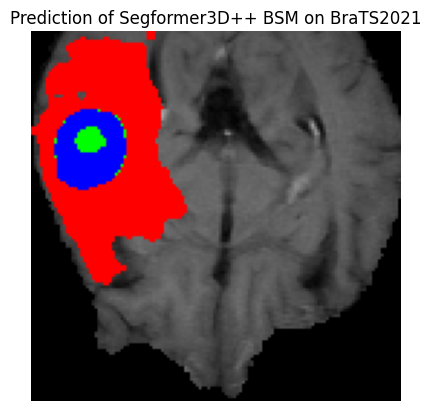

In [88]:
visualize_result(image, output[0],51, title="Prediction of Segformer3D++ BSM on BraTS2021")

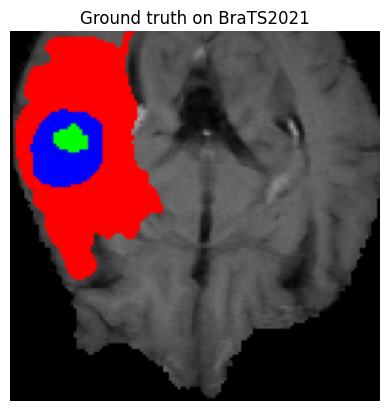

In [89]:
visualize_result(image, label, 51, title="Ground truth on BraTS2021")